In [208]:
%pip install librosa
%pip install pysoundfile
%pip install bitstring

You should consider upgrading via the '/u/dkohar/.venv/omfit_unstable/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/u/dkohar/.venv/omfit_unstable/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/u/dkohar/.venv/omfit_unstable/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [209]:
# all the imports
import os
import librosa
import librosa.display
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt

In [210]:
# sound file

Sampling rate: 48000 samples/second
Signal size: 447680 samples
Signal duration: 9.327 seconds


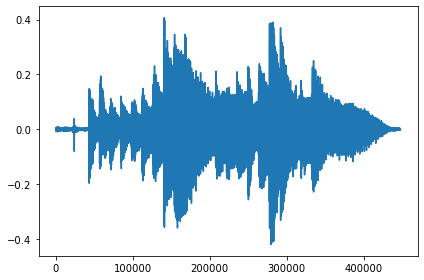

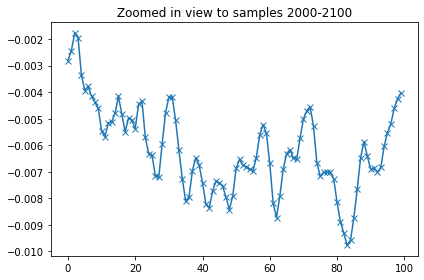

In [211]:
# Plotting the spectrogram
import IPython
wavfile = '/u/dkohar/Sedge St 3.wav'
IPython.display.Audio(wavfile)
#%matplotlib inline
import soundfile
import matplotlib.pyplot as plt
audio_signal, sampling_rate = soundfile.read(wavfile)

print('Sampling rate: {} samples/second'.format(sampling_rate))
print('Signal size: {} samples'.format(audio_signal.shape[0]))
print('Signal duration: {:.3f} seconds'.format(audio_signal.shape[0] / sampling_rate))
plt.plot(audio_signal)
plt.tight_layout()
plt.figure()
plt.plot(audio_signal[2000:2100], marker='x')
plt.title('Zoomed in view to samples 2000-2100')
plt.tight_layout()

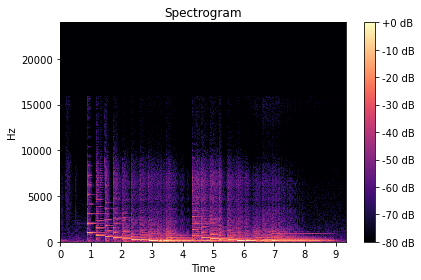

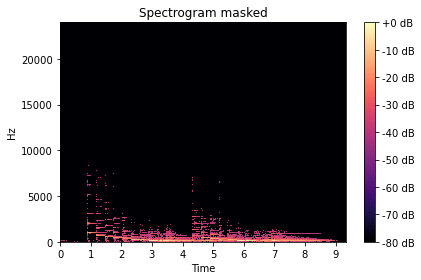

In [212]:
import numpy as np
import librosa
from librosa.display import specshow

n_fft=2048
window_length = int(0.025 * sampling_rate)
hop_length = int(0.01 * sampling_rate)
dt = hop_length / sampling_rate

spectrogram = np.abs(librosa.stft(audio_signal, hop_length=hop_length, win_length=window_length,n_fft=n_fft))
nf, nt = np.shape(spectrogram)
t = np.arange(nt) * dt
f = librosa.fft_frequencies(sr=sampling_rate, n_fft=n_fft)

thresh = .7
mask = (spectrogram > thresh).astype(int)
spectrogram_masked = spectrogram * mask + 1e-8 * (1-mask) 
# Plotting the spectrogram:
specshow(librosa.amplitude_to_db(spectrogram, ref=np.max), sr=sampling_rate, hop_length=hop_length, y_axis='linear', x_axis='time')
plt.title('Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
#plt.ylim(0,2500)
plt.figure()
specshow(librosa.amplitude_to_db(spectrogram_masked, ref=np.max), sr=sampling_rate, hop_length=hop_length, y_axis='linear', x_axis='time')
plt.title('Spectrogram masked')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
#plt.ylim(0,2500)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb

specmax = np.max(spectrogram)
levels = librosa.amplitude_to_db(spectrogram, ref=specmax)
levoff = np.amin(levels)
levels = levels - levoff 
levscale = np.amax(levels) / 255
levels = levels / levscale
levels = np.uint8(levels)
image = np.flip(levels, axis = 0)
fimg = np.flip(f)
timg = t

#mysealevelpower = .5
mysealevel = -50 #librosa.amplitude_to_db(np.array([mysealevelpower]), ref=specmax)[0]
specmin = np.amin(spectrogram)

specdb = librosa.amplitude_to_db(spectrogram, ref=specmax)
mask = (specdb >= mysealevel).astype(int)
spectrogram_masked = spectrogram * mask + specmin * (1-mask)

thresh = mysealevel - levoff
thresh = thresh / levscale
print(mysealevel, thresh)
# apply threshold
#thresh = 100
bw = closing(levels >= thresh, square(3))

# remove artifacts connected to image border
cleared=bw#cleared = clear_border(bw)

# label image regions
label_levels = label(cleared)
label_image = np.flip(label_levels, axis = 0)
# to make the background transparent, pass the value of `bg_label`,
# and leave `bg_color` as `None` and `kind` as `overlay`
image_label_overlay = label2rgb(label_image, image=image, bg_label=0, bg_color=(250,250,250))
extent = np.min(t), np.max(t), np.min(f), np.max(f)

fig, ax = plt.subplots(figsize=(10, 6))
plt.imshow(image_label_overlay, extent=extent, aspect='auto')
plt.ylabel('Hz')
plt.colorbar()

nf = len(f)

"""
for region in regionprops(label_levels):
    # take regions with large enough areas
    if region.area >= 100:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        minf, mint, maxf, maxt = f[minr], t[minc], f[maxr], t[maxc]
        rect = mpatches.Rectangle((mint, minf), maxt - mint, maxf - minf,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
"""
highlevelregions = []
mindt = 0
#mythreshpower = .1
mythresh = mysealevel #librosa.amplitude_to_db(np.array([mythreshpower]), ref=specmax)[0]

for region in regionprops(label_levels):
    mask = label_levels == region.label #true means in region - valid
    specma = ma.masked_array(spectrogram, mask = ~mask) #true means invalid to masked_array
    #print(specma.mean(), mythreshpower) #, specma.max(), specma.min())
    minr, minc, maxr, maxc = region.bbox
    if maxr > len(f)-1: maxr = len(f)-1
    if maxc > len(t)-1: maxc = len(t)-1
    minf, mint, maxf, maxt = f[minr], t[minc], f[maxr], t[maxc]
    mytime = maxt - mint
    mylevel = librosa.amplitude_to_db(np.array([specma.mean()]), ref=specmax)[0]
    #print(mytime, mindt, specma.mean(), mythreshpower)
    if mylevel >= mythresh and mytime >= mindt:
        #print("***")
        #print(specma.mean(), mythreshpower)
        highlevelregions.append(region)
        rect = mpatches.Rectangle((mint, minf), maxt - mint, maxf - minf,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

#ax.set_axis_off()
plt.tight_layout()
plt.show()

# SECOND GRAGH

#plt.ylim(0,2500)
fig, ax = plt.subplots(figsize=(10, 6))


specshow(librosa.amplitude_to_db(spectrogram_masked, ref=np.max), sr=sampling_rate, hop_length=hop_length, y_axis='linear', x_axis='time') 
plt.title('Spectrogram masked')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
#plt.ylim(0,2500)

fig, ax = plt.subplots(figsize=(10, 6))
plt.imshow(np.flip(cleared, axis=0), extent=extent, aspect='auto')
plt.title('Cleared')
plt.ylabel('Hz')
plt.colorbar()
plt.tight_layout()

fig, ax = plt.subplots(figsize=(10, 6))
plt.imshow(image, extent=extent, aspect='auto')
plt.title('Levels')
plt.ylabel('Hz')
plt.colorbar()
plt.tight_layout()

fig, ax = plt.subplots(figsize=(10, 6))
plt.imshow(label_image, extent=extent, aspect='auto')
plt.title('Label')
plt.ylabel('Hz')
plt.colorbar()
plt.tight_layout()



In [290]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border, quickshift, relabel_sequential
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb

specmax = np.max(spectrogram)
levels = librosa.amplitude_to_db(spectrogram, ref=specmax)
levoff = np.amin(levels)
levels = levels - levoff 
levscale = np.amax(levels) / 255
levels = levels / levscale
levels = np.uint8(levels)
image = np.flip(levels, axis = 0)
fimg = np.flip(f)
timg = t

#label_method = 'threshold'
label_method = 'quickshift' 

#mysealevelpower = .5
mysealevel = -50 #librosa.amplitude_to_db(np.array([mysealevelpower]), ref=specmax)[0]
specmin = np.amin(spectrogram)

specdb = librosa.amplitude_to_db(spectrogram, ref=specmax)
mask = (specdb >= mysealevel).astype(int)
spectrogram_masked = spectrogram * mask + specmin * (1-mask)

thresh = mysealevel - levoff
thresh = thresh / levscale
print(mysealevel, thresh)
# apply threshold
#thresh = 100


if label_method is 'threshold':
    bw = closing(levels >= thresh, square(3))
    # remove artifacts connected to image border
    cleared=bw#cleared = clear_border(bw)
    #label image regions
    label_levels = label(cleared)
    
if label_method is 'quickshift':
    #label image regions - alt. version
    label_levels= quickshift(np.repeat(levels[:,:,np.newaxis],3, axis=2)) 

label_image = np.flip(label_levels, axis = 0)
# to make the background transparent, pass the value of `bg_label`,
# and leave `bg_color` as `None` and `kind` as `overlay`
image_label_overlay = label2rgb(label_image, image=image, bg_label=0, bg_color=(250,250,250))

nf = len(f)

highlevelregions = []
mindt = 0
#mythreshpower = .1
mythresh = mysealevel #librosa.amplitude_to_db(np.array([mythreshpower]), ref=specmax)[0]

def clean_label_levels(label_levels, mindt=0, mythresh=mysealevel,relabel=True):
    label_levels_clean = label_levels

    
    for region in regionprops(label_levels):
        mask = label_levels == region.label #true means in region - valid
        specma = ma.masked_array(spectrogram, mask = ~mask) #true means invalid to masked_array
        #print(specma.mean(), mythreshpower) #, specma.max(), specma.min())
        minr, minc, maxr, maxc = region.bbox
        if maxr > len(f)-1: maxr = len(f)-1
        if maxc > len(t)-1: maxc = len(t)-1
        minf, mint, maxf, maxt = f[minr], t[minc], f[maxr], t[maxc]
        mytime = maxt - mint
        mylevel = librosa.amplitude_to_db(np.array([specma.mean()]), ref=specmax)[0]
        #print(mytime, mindt, specma.mean(), mythreshpower)
        if mylevel < mythresh or mytime < mindt:
            label_levels_clean = (~mask)*label_levels_clean
    if relabel:
        label_levels_clean, _ , _ = relabel_sequential(label_levels_clean)
    
    return label_levels_clean

label_levels_clean = clean_label_levels(label_levels, mindt=0, mythresh=-30)
#label_levels_clean_alt = clean_label_levels(label_levels, mindt=.1, mythresh=mysealevel+10)

label_image_clean = np.flip(label_levels_clean, axis = 0)
image_label_overlay_clean = label2rgb(label_image_clean, image=image, bg_label=0, bg_color=(250,250,250))

-50 95.625


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


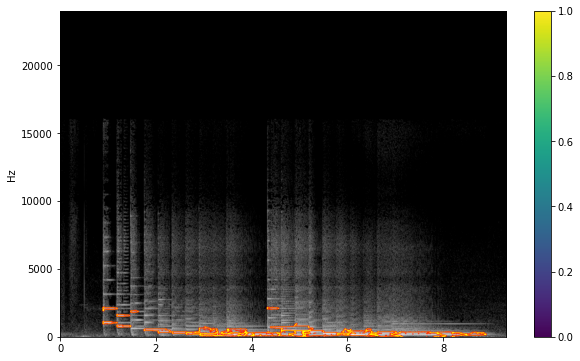

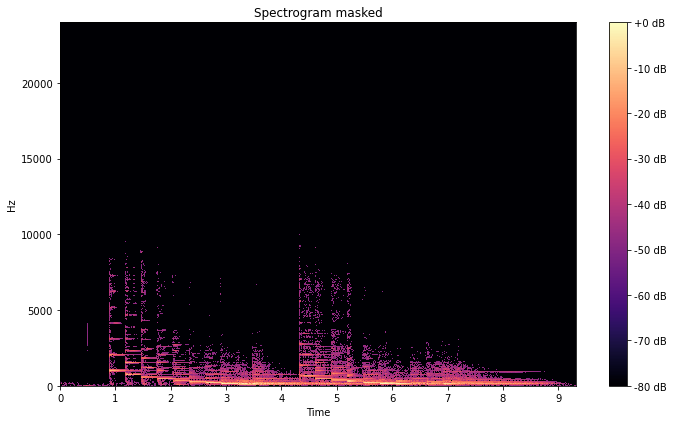

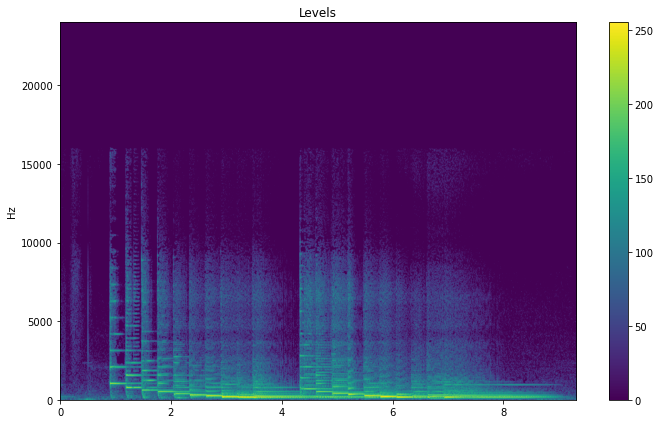

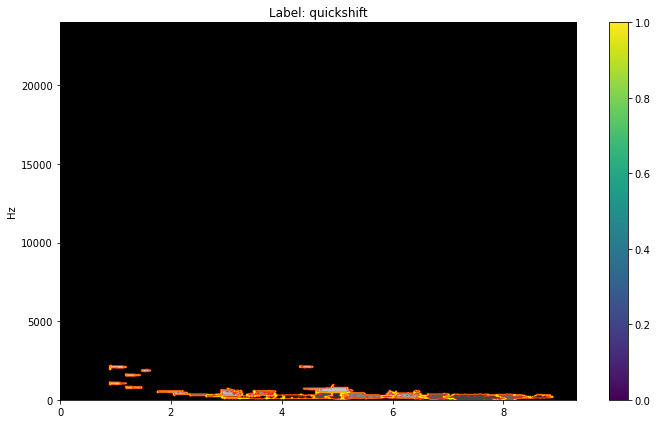

In [291]:
from skimage.segmentation import mark_boundaries
#boundary_method = 'drawboxes'
boundary_method = 'mark_boundaries'
label_image_plot = label_image_clean
#label_image_plot = label_image
image_label_overlay_plot = image_label_overlay_clean
#image_label_overlay_plot = image_label_overlay
label_levels_plot = label_levels_clean
#label_levels_plot = label_levels

def drawboxes(label_levels, ax, mindt=0, mythresh=mysealevel):

    for region in regionprops(label_levels):
        mask = label_levels == region.label #true means in region - valid
        specma = ma.masked_array(spectrogram, mask = ~mask) #true means invalid to masked_array
        #print(specma.mean(), mythreshpower) #, specma.max(), specma.min())
        minr, minc, maxr, maxc = region.bbox
        if maxr > len(f)-1: maxr = len(f)-1
        if maxc > len(t)-1: maxc = len(t)-1
        minf, mint, maxf, maxt = f[minr], t[minc], f[maxr], t[maxc]
        mytime = maxt - mint
        mylevel = librosa.amplitude_to_db(np.array([specma.mean()]), ref=specmax)[0]
        #print(mytime, mindt, specma.mean(), mythreshpower)
        if mylevel >= mythresh and mytime >= mindt:
            #print("***")
            #print(specma.mean(), mythreshpower)
            #highlevelregions.append(region)
            rect = mpatches.Rectangle((mint, minf), maxt - mint, maxf - minf,
                                      fill=False, edgecolor='red', linewidth=2)
            ax.add_patch(rect)

            
extent = np.min(t), np.max(t), np.min(f), np.max(f)

fig, ax = plt.subplots(figsize=(10, 6))
if boundary_method is 'drawboxes':
    plt.imshow(image_label_overlay_plot, extent=extent, aspect='auto')
    plt.ylabel('Hz')
    plt.colorbar()

    #nf = len(f)

    mindt = 0
    #mythreshpower = .1
    mythresh = mysealevel #librosa.amplitude_to_db(np.array([mythreshpower]), ref=specmax)[0]

    drawboxes(label_levels_plot, ax, mindt=mindt, mythresh=mythresh)
else:
    image_label_overlay_marked_boundaries = mark_boundaries(image, label_image_plot, outline_color=(255,0,0))
    #image_label_overlay_marked_boundaries = mark_boundaries(np.flip(librosa.amplitude_to_db(spectrogram, ref=specmax), axis=0), label_image)
    plt.imshow(image_label_overlay_marked_boundaries, extent=extent, aspect='auto')
    plt.ylabel('Hz')
    plt.colorbar()
    

#ax.set_axis_off()
#plt.tight_layout()
#plt.show()

# SECOND GRAGH

#plt.ylim(0,2500)
fig, ax = plt.subplots(figsize=(10, 6))

specshow(librosa.amplitude_to_db(spectrogram_masked, ref=np.max), sr=sampling_rate, hop_length=hop_length, y_axis='linear', x_axis='time') 
plt.title('Spectrogram masked')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
#plt.ylim(0,2500)

#image 3, "levels"
fig, ax = plt.subplots(figsize=(10, 6))
plt.imshow(image, extent=extent, aspect='auto')
plt.title('Levels')
plt.ylabel('Hz')
plt.colorbar()
plt.tight_layout()


#image 4, "label"
fig, ax = plt.subplots(figsize=(10, 6))
plt.imshow(mark_boundaries(label_image_plot/np.max(label_image_plot), label_image_plot, outline_color=(255,0,0)), extent=extent, aspect='auto')
#plt.imshow(label_image, extent=extent, aspect='auto')
plt.title('Label: ' + label_method)
plt.ylabel('Hz')
plt.colorbar()
plt.tight_layout()

In [262]:
print(np.sum(label_levels==0))

8


In [217]:
for i,I in enumerate(In): print(f'In[{i}]: {I}')

In[0]: 
In[1]: # all the imports
import os
import librosa
import librosa.display
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt
In[2]: get_ipython().run_line_magic('pip', 'install librosa')
get_ipython().run_line_magic('pip', 'install pysoundfile')
In[3]: # all the imports
import os
import librosa
import librosa.display
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt
In[4]: # all the imports
import os
import librosa
import librosa.display
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt
In[5]: # Plotting the spectrogram
import IPython
wavfile = '/u/dkohar/Sedge St 3.wav'
IPython.display.Audio(wavfile)
#%matplotlib inline
import soundfile
import matplotlib.pyplot as plt
audio_signal, sampling_rate = soundfile.read(wavfile)

print('Sampling rate: {} samples/second'.format(sampling_rate))
print('Signal size: {} samples'.format(audio_signal.shape[0]))
print('Signal duration: {:.3f} seconds'.f

In [218]:
x = np.array([1, 2, 3, -1, 5])
msk = x>3 #true for valid elements
mx = ma.masked_array(x, mask= ~msk) #masked array treats true as meaning invalid
print(mx.mean())

print(msk)


5.0
[False False False False  True]


In [219]:
print(len(highlevelregions))

32


In [220]:
mask = label_image == 1
specma = ma.masked_array(spectrogram, mask = mask)
print(specma.mean(), specma.max(), specma.min())

0.17823043821627316 107.69539835825552 6.231052318561581e-08


In [221]:
print(np.sum(mask))

2


In [222]:
for ij in(np.argwhere(mask)):
    print(spectrogram[ij[0],ij[1]])

0.00021164874781634627
0.00014694358820966036


In [223]:
import skimage
skimage.__version__

'0.18.1'

In [224]:
print([(i,r.area) for i,r in enumerate(regionprops(label_image)) if r.area>100])

[(36, 196), (40, 301), (47, 233), (91, 133), (140, 278), (143, 104), (171, 135), (201, 360), (218, 169), (220, 232), (226, 223), (230, 198), (231, 300), (238, 102), (271, 746), (284, 146), (302, 452), (303, 210), (307, 600), (314, 349), (329, 349), (330, 320)]
